In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.fft import fft, ifft
import pandas as pd
import glob
import sipm.util.functions as func
from datetime import datetime
plt.style.use('darkside')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
!pwd


/home/nwoofter/sipm-analysis


In [5]:
data_dir = '/scratch/gpfs/nwoofter/results/2023-06-07/*/'
glob.glob(data_dir)

[]

# Load pre-processed h5 files
These files should be processed by `exe/laser_pulse.py` script.

In [11]:
# data folder
path = "/scratch/gpfs/nwoofter/results/2023-06-07/"
data = {}
intensity = [1020]
channels = [0, 1, 2]
voltages = 90
for intn in intensity:
    data[intn] = {}
    for ch in channels:
        data[intn][ch] = {'n_spe_wfs':0, 'avg_spe_wf':np.zeros(0), 'time':np.zeros(0)}
        files = glob.glob(f"{path}/*intensity_{intn}*_wf.h5")
        print(files)
        for f in files:
            df = pd.read_hdf(f, key=f'{voltages}/{ch}')
            print(df)
            data[intn][ch]['n_spe_wfs'] += np.array(df['n_spe_wfs'])[0]
            if data[intn][ch]['time'].shape[0]==0:
                data[intn][ch]['time'] = np.array(df['time'])
            if data[intn][ch]['avg_spe_wf'].shape[0]==0:
                data[intn][ch]['avg_spe_wf'] = np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
            else:
                data[intn][ch]['avg_spe_wf'] += np.array(df['avg_spe_wf'])*np.array(df['n_spe_wfs'])[0]
            df = None
            data[intn][ch]['avg_spe_wf'] /= data[intn][ch]['n_spe_wfs']
print('keys: ', list(data[1020][0].keys()))

['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0_wf.h5']
      n_spe_wfs  avg_spe_wf    time
0       14630.0   -0.495014   0.000
1           NaN    0.516879   0.004
2           NaN   -0.507728   0.008
3           NaN    0.540461   0.012
4           NaN   -0.493920   0.016
...         ...         ...     ...
3995        NaN    0.578534  15.980
3996        NaN   -0.529874  15.984
3997        NaN    0.502457  15.988
3998        NaN   -0.492417  15.992
3999        NaN    0.563223  15.996

[4000 rows x 3 columns]
['/scratch/gpfs/nwoofter/results/2023-06-07/2023-06-07_volt_90_light_laser_cond_ln_intensity_1020_config_1_intensity_1020_run0_wf.h5']
      n_spe_wfs  avg_spe_wf    time
0       16751.0   -0.442159   0.000
1           NaN    0.337197   0.004
2           NaN   -0.567943   0.008
3           NaN    0.435759   0.012
4           NaN   -0.397027   0.016
...         ...         ...     ...
3995        NaN    0.

In [7]:
intn = 1020
ch = 0
volt = 90
data[intn][ch]

{'n_spe_wfs': 14630.0,
 'avg_spe_wf': array([-0.49501398,  0.51687939, -0.50772759, ...,  0.50245697,
        -0.49241658,  0.56322252]),
 'time': array([0.0000e+00, 4.0000e-03, 8.0000e-03, ..., 1.5988e+01, 1.5992e+01,
        1.5996e+01])}

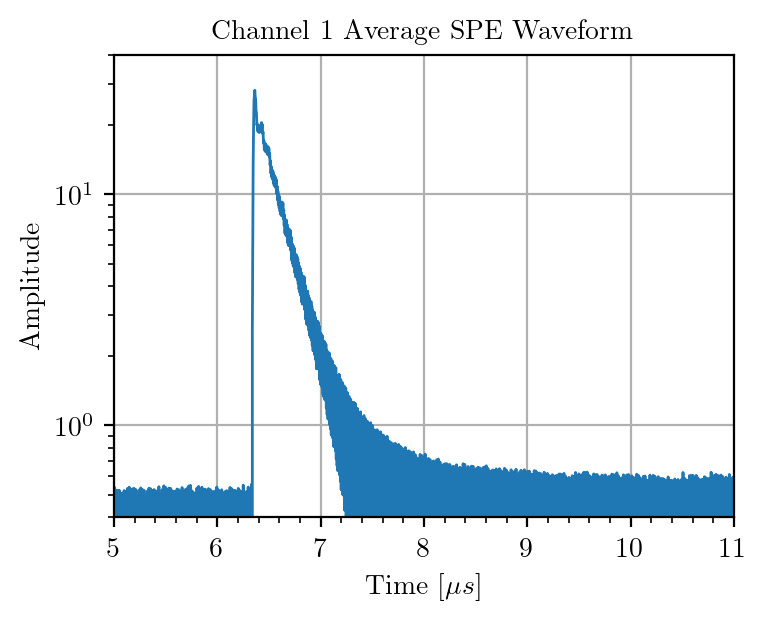

In [8]:
intn = 1020
ch = 0

plt.plot(data[intn][ch]['time'], data[intn][ch]['avg_spe_wf'], linewidth = '1')
plt.minorticks_on()
plt.title('Channel 1 Average SPE Waveform')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xlim(5, 11)
plt.ylim(0.4, 40)
plt.grid()

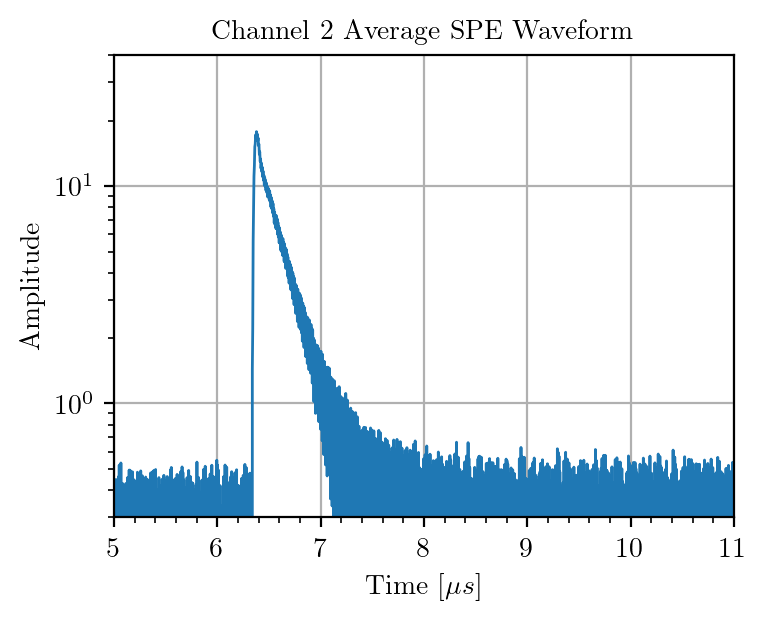

In [43]:
intn = 1020
ch = 1

plt.plot(data[intn][ch]['time'], data[intn][ch]['avg_spe_wf'], linewidth = '1')
plt.minorticks_on()
plt.title('Channel 2 Average SPE Waveform')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xlim(5, 11)
plt.ylim(0.3, 40)
plt.grid()

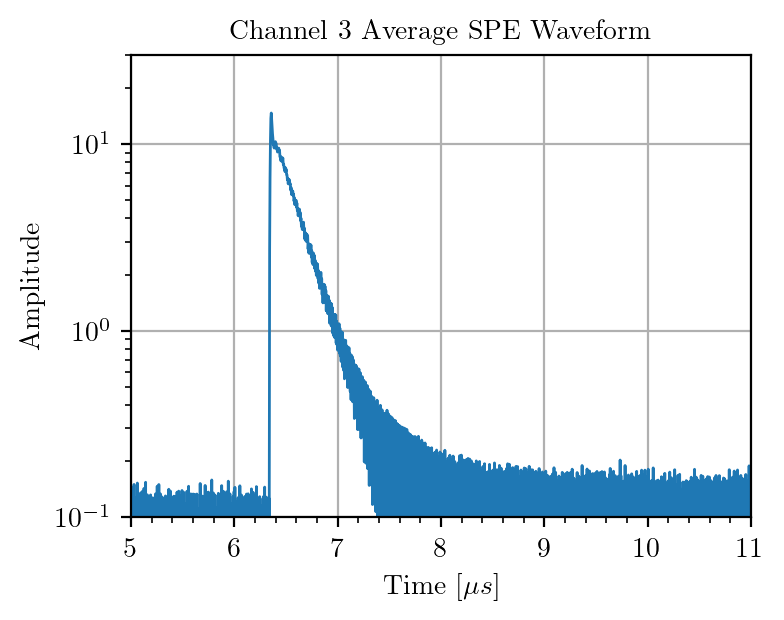

In [51]:
intn = 1020
ch = 2

plt.plot(data[intn][ch]['time'], data[intn][ch]['avg_spe_wf'], linewidth = '1')
plt.minorticks_on()
plt.title('Channel 3 Average SPE Waveform')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Amplitude')
plt.yscale('log')
plt.xlim(5, 11)
plt.ylim(0.1, 30)
plt.grid()

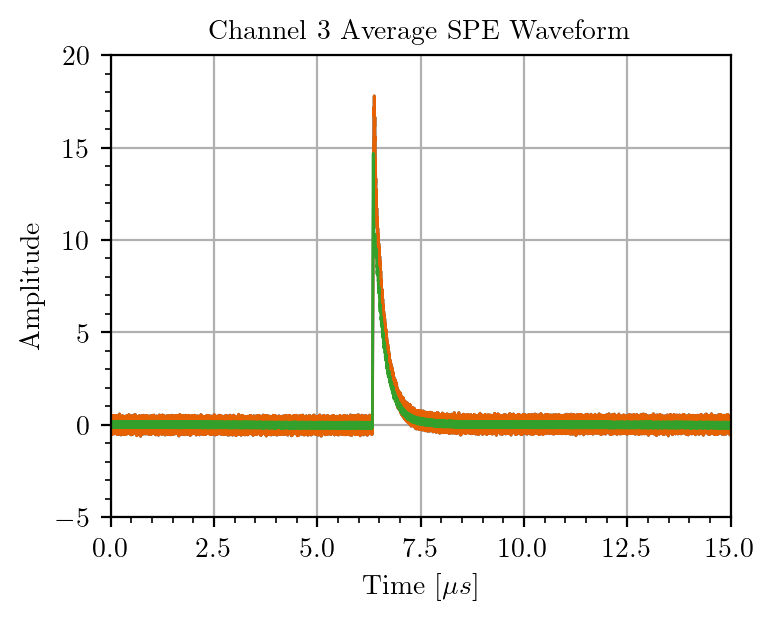

In [45]:
intn = 1020
ch = 1

plt.plot(data[intn][ch]['time'], data[intn][ch]['avg_spe_wf'], linewidth = '1')
plt.plot(data[intn][1]['time'], data[intn][1]['avg_spe_wf'], linewidth = '1')
plt.plot(data[intn][2]['time'], data[intn][2]['avg_spe_wf'], linewidth = '1')
plt.minorticks_on()
plt.title('Channel 3 Average SPE Waveform')
plt.xlabel(r'Time [$\mu s$]')
plt.ylabel('Amplitude')
plt.xlim(0, 15)
plt.grid()

In [9]:
def template(t, a_1, tau_1, a_2, tau_2, sigma, t0):
        return func.pulse_jitter(t, a_1, tau_1, sigma, t0) + func.pulse_jitter(t, a_2, tau_2, sigma, t0)

In [14]:
# Fit SPE average waveform
for i, intn in enumerate(intensity):
    for j, ch in enumerate(channels):
        pretrg = 5 #us
        err = np.std(data[intn][ch]['avg_spe_wf'][data[intn][ch]['time']<pretrg])
        fit_range = [6.2,10] #us
        range_arr = (data[intn][ch]['time']<fit_range[1])&(data[intn][ch]['time']>fit_range[0])
        # print(intn,ch,volt)
        # print(data[intn][ch]['time'][range_arr])
        # print(data[intn][ch]['avg_spe_wf'][range_arr])
        popt,pcov = curve_fit(
            template,
            data[intn][ch]['time'][range_arr], 
            data[intn][ch]['avg_spe_wf'][range_arr], 
            p0=[7, 0.05, 6, 0.7, 0.008, 6.34], sigma=err*np.ones(np.sum(range_arr)), maxfev=100000)
        data[intn][ch]['pars'] = popt
        data[intn][ch]['cov'] = pcov

TypeError: 'int' object is not subscriptable

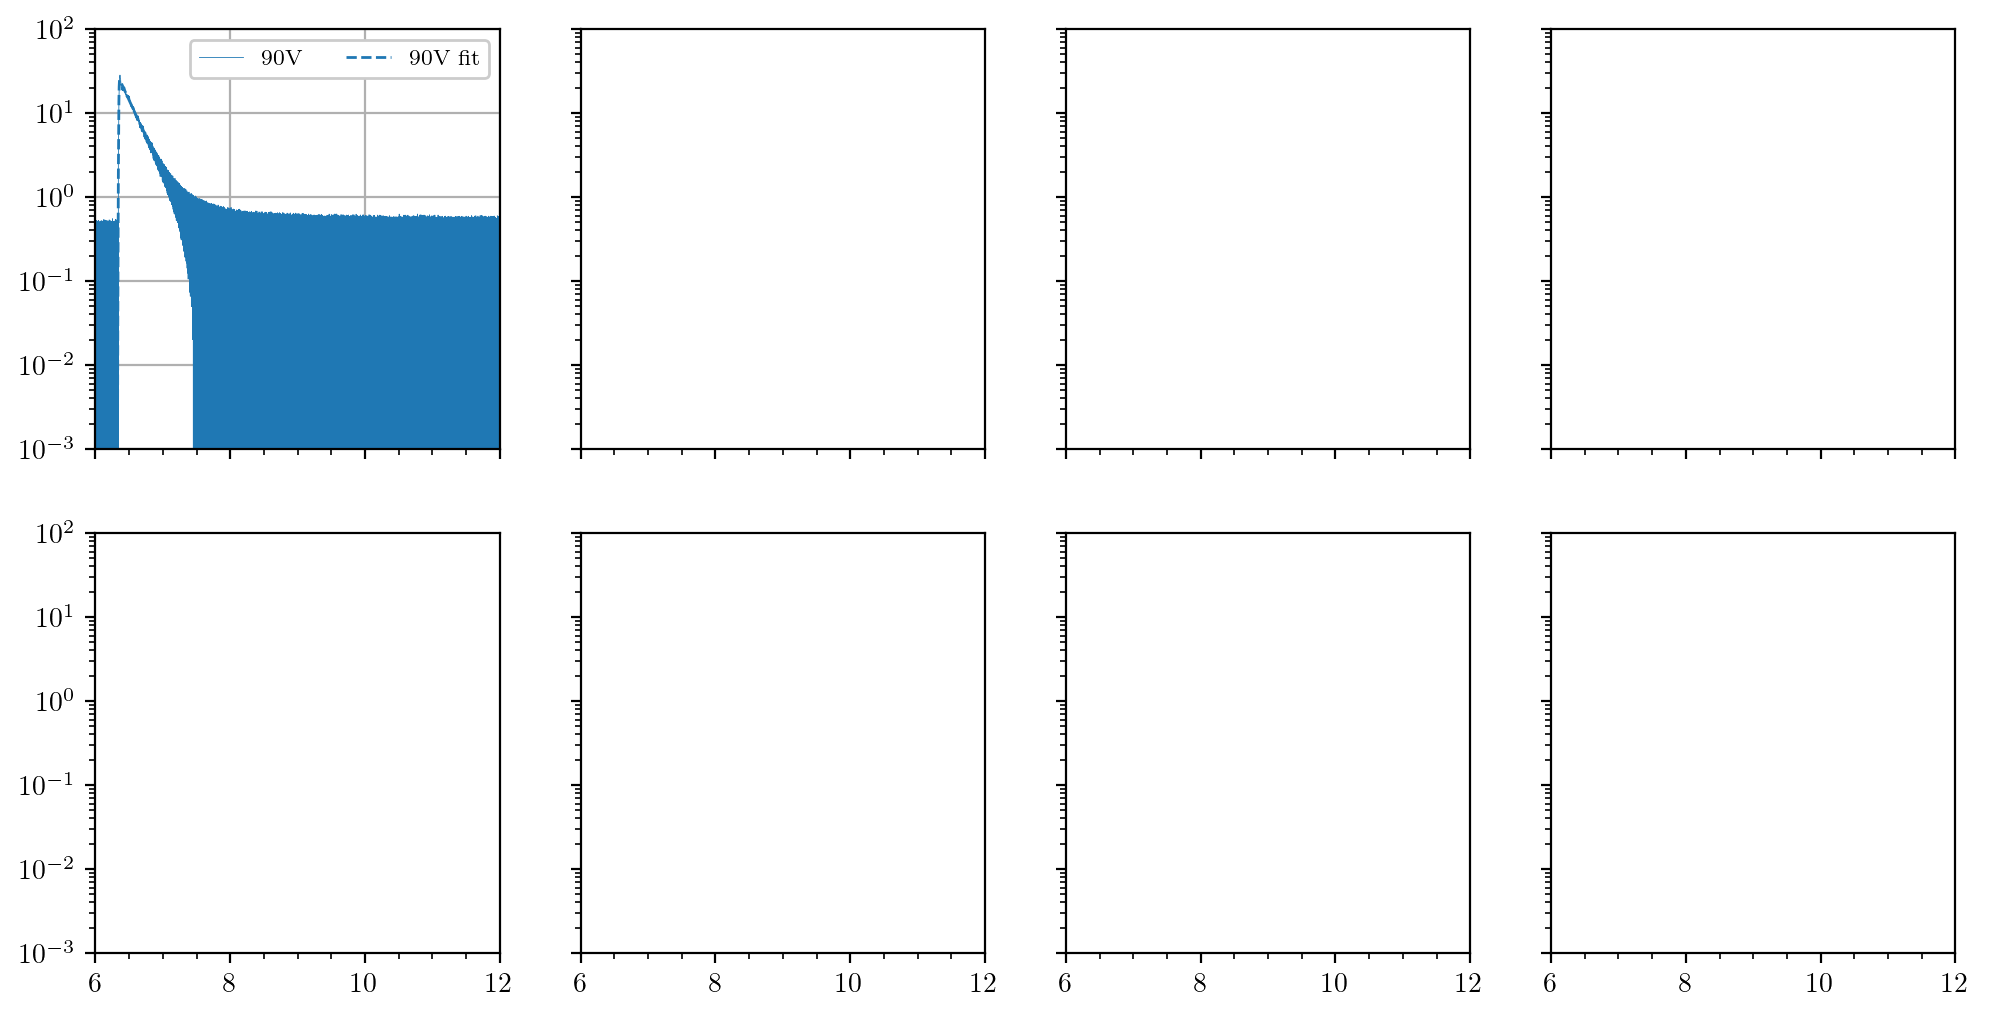

In [17]:
# Make plots for all datasets
# Fitted SPE average waveform
k = 90
fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)
fig.set_size_inches(12, 6)
for i, intn in enumerate(intensity):
    for j, ch in enumerate(channels):
        axs[i, j].plot(
            data[intn][ch]['time'],
            data[intn][ch]['avg_spe_wf'],
            label=f'{volt}V', color=f'C{k}', linewidth=0.3)
        axs[i, j].plot(
            data[intn][ch]['time'],
            template(data[intn][ch]['time'], *data[intn][ch]['pars']),
            label=f'{volt}V fit', color=f'C{k}', linestyle='--', linewidth=1)
        axs[i, j].legend(loc='upper right',ncol=2)
        axs[i, j].set_xlim(6, 12)
        axs[i, j].set_ylim(1e-3, 1e2)
        axs[i, j].set_yscale('log')
        axs[i, j].minorticks_on()
        axs[i, j].grid()
        axs[i, j].set_title(f'{intn[0].upper()}{intn[1:]} Ch{ch}')
fig.supxlabel(r'Time ($\mu$s)', y=0.01)
fig.supylabel(r'Amplitude (ADC Unit)', x=0.07)